### Here we will identify some parameters of the biogeochemical model (see brom_functions.py). The last figure shows modelled Chlorophyll a distribution compared to observed values.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import brom_functions as bf
import plot_functions as pf
import lmfit as lf
import non_linear_fit_functions as lff

#### Open an initial dataset (observed values)

In [2]:
ds = xr.open_dataset('wadden_sea_out.nc')
df = ds.to_dataframe()

In [3]:
levelcntr = df.groupby('levelcntr').get_group(0.625)
levelface = levelcntr.groupby('levelface').get_group(0)
levelface.describe()

,par,hice,snowthick,icesurft,temperature,salinity,sigma,turbulence,ammonium,nitrate,sulfate,silicate,phosphate,oxygen,om_flux,chl_a
count,1095.000000,1095.0,1095.0,1095.0,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.0,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000
mean,56.332397,0.0,0.0,0.0,10.700646,30.484438,25.608339,0.000036,3.430137,16.124231,25000.0,10.462073,0.616338,332.543217,0.001389,4.910959
std,23.048964,0.0,0.0,0.0,5.691322,0.708197,1.594859,0.000031,3.281771,13.724963,0.0,8.133727,0.406156,47.042972,0.000393,5.743140
min,21.644333,0.0,0.0,0.0,2.145531,29.219625,22.645143,0.000009,0.000000,0.198307,25000.0,0.754375,0.094500,255.017806,0.000833,2.000000
25%,33.247036,0.0,0.0,0.0,5.767865,29.952813,24.353865,0.000019,0.000000,0.907292,25000.0,3.564215,0.241964,294.762602,0.000997,2.000000
50%,58.778526,0.0,0.0,0.0,10.443795,30.572593,25.663931,0.000025,4.000000,16.035938,25000.0,5.939955,0.563480,324.720360,0.001389,2.000000
75%,79.421547,0.0,0.0,0.0,16.023899,30.967065,26.740268,0.000041,7.000000,28.764583,25000.0,19.211458,0.918029,362.263498,0.001781,3.322115
max,86.162720,0.0,0.0,0.0,19.109524,32.490208,29.768699,0.000312,8.000000,40.072916,25000.0,26.070694,1.504752,427.340630,0.001944,22.868750


In [4]:
par = levelface['par'].values[0:365].astype(np.float64)
temperature = levelface['temperature'].values[0:365].astype(np.float64)
nh4_data = levelface['ammonium'].values[0:365].astype(np.float64)
no3_data = levelface['nitrate'].values[0:365].astype(np.float64)
po4_data = levelface['phosphate'].values[0:365].astype(np.float64)
si_data = levelface['silicate'].values[0:365].astype(np.float64)
o2_data = levelface['oxygen'].values[0:365].astype(np.float64)
chl_a_data = levelface['chl_a'].values[0:365].astype(np.float64)
# it is assumed for flux to be for each layer, but here it should be total flux (just multiply it by 2.5), in result it will be like all om comes to the box of m^3, so it is also false
om_flux = levelface['om_flux'].values[0:365].astype(np.float64)
# daily irradiance
irradiance = par*86400/1000000 # convertion microM per second to M per day

#### There are some initial data

In [5]:
#some common variables
depth = 0.625; k=0; latitude=54.88; days = np.arange(0,364,1)
#nutrients
nh4 = np.zeros(365); nh4[0] = nh4_data[0]
no2 = np.zeros(365); no2[0] = 0
no3 = np.zeros(365); no3[0] = no3_data[0] 
si = np.zeros(365); si[0] = si_data[0] 
po4 = np.zeros(365); po4[0] = po4_data[0] 
o2 = np.zeros(365); o2[0] = o2_data[0] 
#phy
phy = np.zeros(365); phy[0] = 1
# daily irradiance, convertion microM per second to M per day
irradiance = par*86400/1000000
#het
het = np.zeros(365); het[0] = 1
#om
pom = np.zeros(365); pom[0] = 100
dom = np.zeros(365); dom[0] = 50

#### There are some initial parameters (from the literature)

In [6]:
#horizontal advection
k_mix=900
#phy
knh4_lim=5; knox_lim=5; ksi_lim=0.1; kpo4_lim=0.1; pbm=3; alpha=0.075; kexc=0.015; kmortality=0.00001
#het
k_het_phy_gro=0.2; k_het_phy_lim=0.3; k_het_pom_gro=0.2; k_het_pom_lim=0.3
k_het_res=0.015; k_het_mort=0.1; uz=0.5; hz=0.5
#nitrification
k_nfix = 0.4; k_nitrif1=0.1; k_nitrif2=0.1; o2s_nf=5; k_anammox=0.8; o2s_dn=10
#om respiration
k_pom_dom=0.15; k_omox_o2=1; tref=0
k_dom_ox=0.1; k_pom_ox=0.002

#### Run simulation - 1

In [7]:
chl_a, phy_dgrate, rations = bf.calculate(
    depth, k, k_mix, latitude, days, temperature, 
    nh4, no2, no3, si, po4, o2,
    nh4_data, no3_data, si_data, po4_data, o2_data,
    phy, par, irradiance, 
    knh4_lim, knox_lim, ksi_lim, kpo4_lim, pbm, alpha, kexc, kmortality,
    het,
    k_het_phy_gro, k_het_phy_lim, k_het_pom_gro, k_het_pom_lim, k_het_res, k_het_mort, uz, hz,
    k_nfix, k_nitrif1, k_nitrif2, o2s_nf, k_anammox, o2s_dn,
    pom, dom, om_flux,
    k_pom_dom, k_omox_o2, tref, k_dom_ox, k_pom_ox)

#### The initial (with average parameters from the literature) chlorophyll a distribution: model vs data

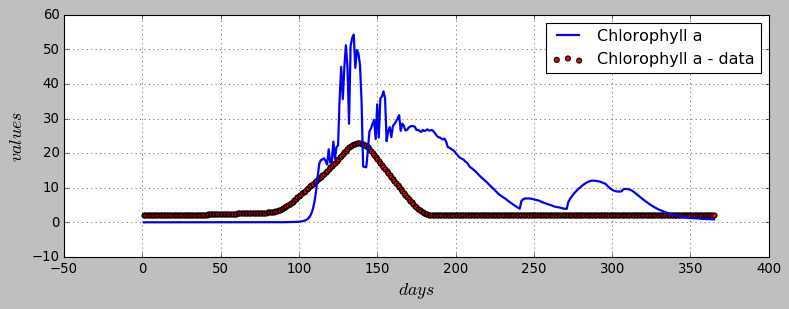

In [8]:
pf.plot_double(chl_a,'Chlorophyll a',chl_a_data,'Chlorophyll a - data')

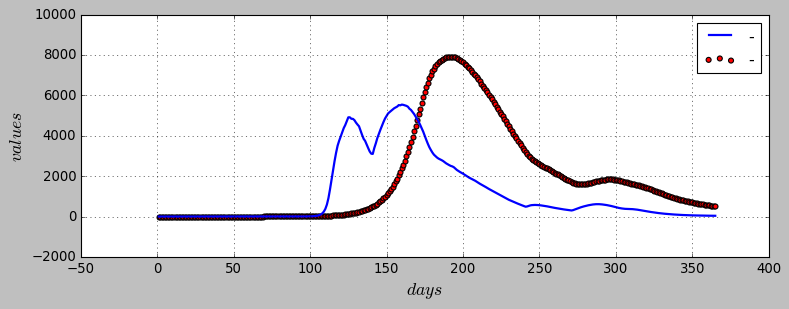

In [9]:
pf.plot_double(phy,'-',het,'-')

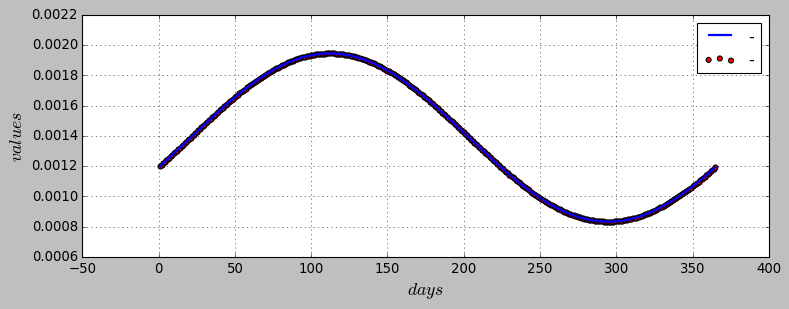

In [10]:
pf.plot_double(om_flux,'-',om_flux,'-')

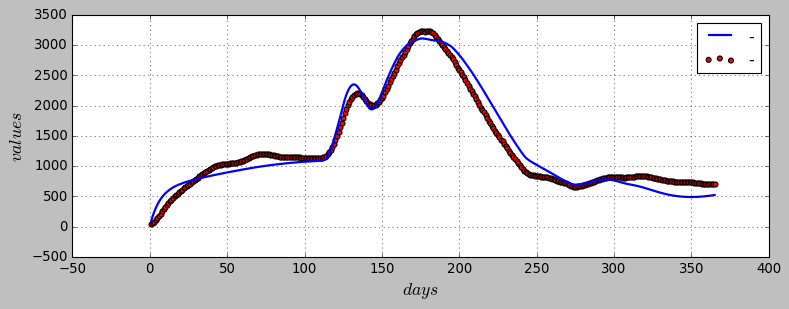

In [11]:
pf.plot_double(pom,'-',dom,'-')

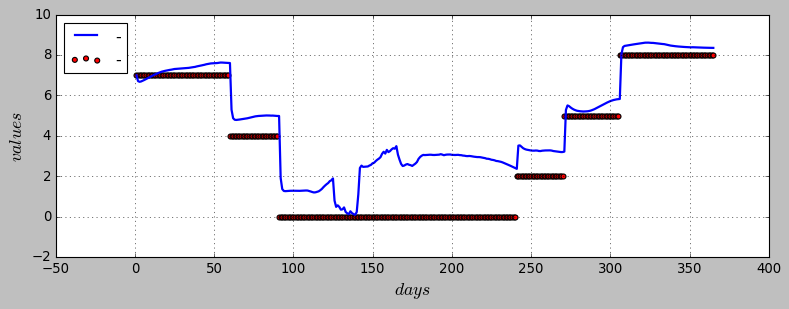

In [12]:
pf.plot_double(nh4,'-',nh4_data,'-')

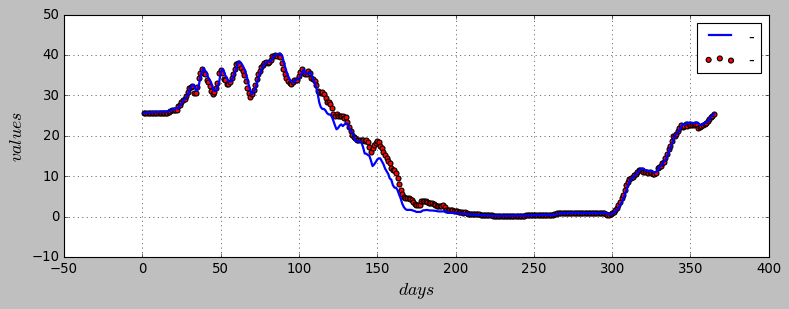

In [13]:
pf.plot_double(no3,'-',no3_data,'-')

#### Run least squares for phytoplankton - resudial function is constructed according to chl_a_data

In [24]:
params = lf.Parameters()
#horizontal advection
params.add('k_mix', value=k_mix, min=700, max=1100)
#phy
params.add('knh4_lim', value=knh4_lim, min=1, max=15)
params.add('knox_lim', value=knox_lim, min=1, max=15)
params.add('ksi_lim', value=ksi_lim, min=0.1)
params.add('kpo4_lim', value=kpo4_lim, min=0.1)
params.add('pbm', value=pbm, min=1, max=5)
params.add('alpha', value=alpha, min=0.05, max=0.09)
params.add('kexc', value=kexc, vary=False)
params.add('kmort', value=kmortality, vary=False)
#het
params.add('k_het_phy_gro', value=k_het_phy_gro, vary=False)
params.add('k_het_phy_lim', value=k_het_phy_lim, vary=False)
params.add('k_het_pom_gro', value=k_het_pom_gro, vary=False)
params.add('k_het_pom_lim', value=k_het_pom_lim, vary=False)
params.add('k_het_res', value=k_het_res, vary=False)
params.add('k_het_mort', value=k_het_mort, vary=False)
params.add('uz', value=uz, vary=False)
params.add('hz', value=hz, vary=False)
#nitrification
params.add('k_nfix', value=k_nfix, vary=False)
params.add('k_nitrif1', value=k_nitrif1, vary=False)
params.add('k_nitrif2', value=k_nitrif2, vary=False)
params.add('o2s_nf', value=o2s_nf, vary=False)
params.add('k_anammox', value=k_anammox, vary=False)
params.add('o2s_dn', value=o2s_dn,vary=False)
#OM
params.add('k_pom_dom', value=k_pom_dom, vary=False)
params.add('k_omox_o2', value=k_omox_o2, vary=False)
params.add('tref', value=tref, vary=False)
params.add('k_dom_ox', value=k_dom_ox, vary=False)
params.add('k_pom_ox', value=k_pom_ox, vary=False)

In [25]:
mini = lf.Minimizer(lff.residual_phy, params,
                    fcn_args=(depth, k, latitude, days, temperature,
                              nh4, no2, no3, si, po4, o2,
                              nh4_data, no3_data, si_data, po4_data, o2_data,
                              phy, par, irradiance,
                              het,
                              pom, dom, om_flux,
                              chl_a_data))

In [26]:
foo = lff.run_least_squares(mini)

#### Update new parameter values

In [27]:
k_mix = lff.return_par_values(foo, 'k_mix')
knh4_lim = lff.return_par_values(foo, 'knh4_lim')
knox_lim = lff.return_par_values(foo, 'knox_lim')
ksi_lim = lff.return_par_values(foo, 'ksi_lim')
kpo4_lim = lff.return_par_values(foo, 'kpo4_lim')
pbm    = lff.return_par_values(foo, 'pbm')
alpha    = lff.return_par_values(foo, 'alpha')
k_het_phy_gro = lff.return_par_values(foo, 'k_het_phy_gro')
k_het_phy_lim = lff.return_par_values(foo, 'k_het_phy_lim')
k_het_pom_gro = lff.return_par_values(foo, 'k_het_pom_gro')
k_het_pom_lim = lff.return_par_values(foo, 'k_het_pom_lim')

In [28]:
print(k_mix)
print(knh4_lim); print(knox_lim);
print(ksi_lim); print(kpo4_lim)
print(pbm); print(alpha)
#print(k_het_phy_gro); print(k_het_phy_lim)
#print(k_het_pom_gro); print(k_het_pom_lim)

713.4033304868854
7.0316384828424985
14.937548055661308
0.1
0.1
2.759650587591365
0.0898348008649569


In [29]:
chl_a, phy_dgrate, rations = bf.calculate(
    depth, k, k_mix, latitude, days, temperature, 
    nh4, no2, no3, si, po4, o2,
    nh4_data, no3_data, si_data, po4_data, o2_data,
    phy, par, irradiance, 
    knh4_lim, knox_lim, ksi_lim, kpo4_lim, pbm, alpha, kexc, kmortality,
    het,
    k_het_phy_gro, k_het_phy_lim, k_het_pom_gro, k_het_pom_lim, k_het_res, k_het_mort, uz, hz,
    k_nfix, k_nitrif1, k_nitrif2, o2s_nf, k_anammox, o2s_dn,
    pom, dom, om_flux, 
    k_pom_dom, k_omox_o2, tref, k_dom_ox, k_pom_ox)

#### The chlorophyll a distribution: model vs data (with some parameters established with LMFIT)

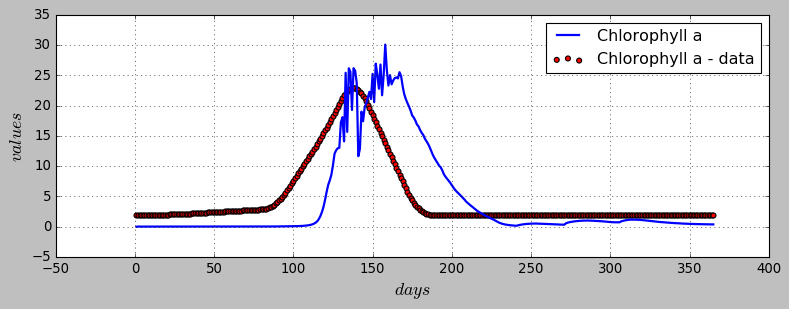

In [30]:
pf.plot_double(chl_a,'Chlorophyll a',chl_a_data,'Chlorophyll a - data')

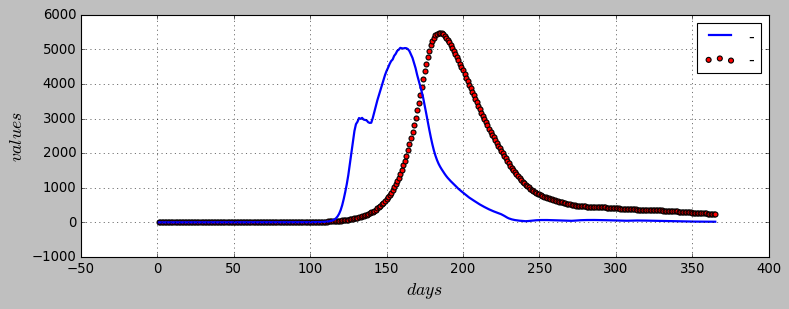

In [31]:
pf.plot_double(phy,'-',het,'-')

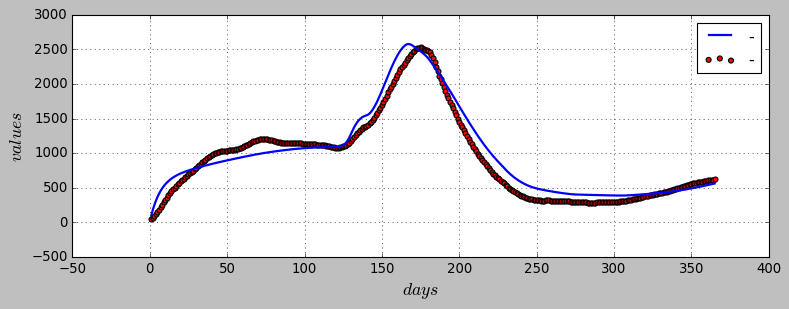

In [32]:
pf.plot_double(pom,'-',dom,'-')

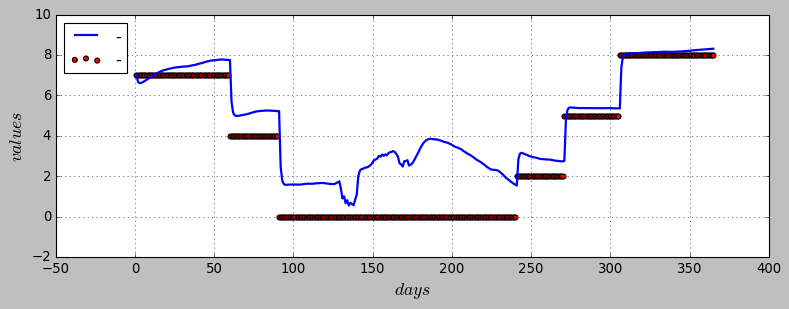

In [33]:
pf.plot_double(nh4,'-',nh4_data,'-')